# Information Given in Documentation
[https://www.bbci.de/competition/iv/desc_2a.pdf](http://)

*   25 electrodes are used, first 22 are EEG, last 3 are EOG
*   Sampling frequency (fs) is 250Hz
*   9 subjects

**-Time Duration:-**
*  1 trials = 7-8s
*  1 run = 48 trials = 336-384s
*  1 session = 6 runs = 288 trials = 2016-2304s   9 run (run 1-3 are for eye movement, run 4-9 is MI)

**About the recording of eye movement**

*     run 1 => 2 mins with eyes open
*     run 2 => 1 min with eyes closed
*     run 3 => 1 min with eye movements



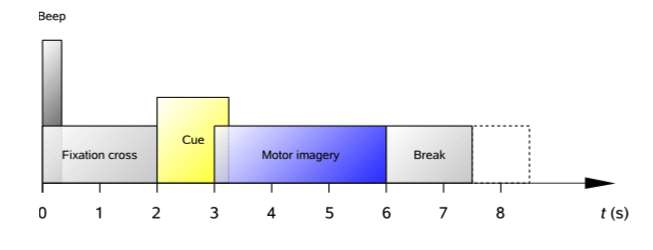

**Explanation regarding contents of the keys inside each subject data:**
*     **s:** 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
*     **etype:** 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
*     **epos:** 'epos' stands for event position, denoting corresponding event begins at n-th sample at 's'
*    **edur:** 'edur' stands for event duration, denoting duration of corresponding event
*    **artifacts:** size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials


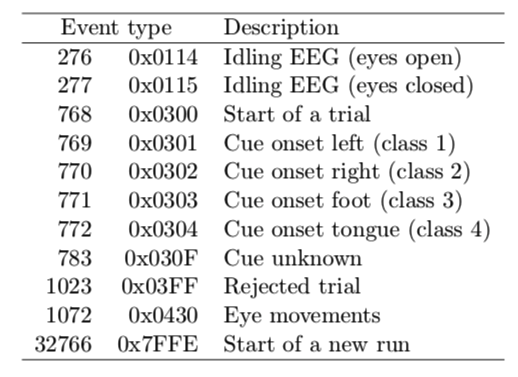

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.linalg import sqrtm
from scipy.linalg import inv
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
# Band pass filter with butterworth filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [2]:
# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
Number_subject = 10

# Creating dict to store original data and modified data
# original_data will serve as initial loaded data that will remain unchanged
# modified_data will contain modified original data
original_data = dict()
modified_data = dict() 
original_dataE = dict() 
modified_dataE = dict() 
 

In [3]:
# Function to count subject
def subject_counter(i):
    return 'subject0{}'.format(i)

In [4]:
base_dir ="/kaggle/input/dataset-2"
base_dirE ="/kaggle/input/dataset-2"
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, Number_subject):
    data_path = os.path.join(base_dir, 'A{:02d}T.npz'.format(i))
    data_pathE = os.path.join(base_dirE, 'A{:02d}E.npz'.format(i))
    subject = 'subject{:02d}'.format(i)
    
    # Load EEG data from datapath and store into subj0X variabel then store into data dictionary
    original_data[subject] = np.load(data_path)
    original_dataE[subject] = np.load(data_pathE)

In [5]:
# Peek into ori_data type and its keys 
print(type(original_data['subject01']))#This line prints the type of the object associated with the key 
print(original_data['subject01'].files)# list of files contained within the NpzFile object.it converts a multi-dimensional array into a one-dimensional array
print('#########################################################################################')
print(type(original_dataE['subject01']))#This line prints the type of the object associated with the key 
print(original_dataE['subject01'].files)# list of files contained within the NpzFile object.it converts a multi-dimensional array into a one-dimensional array

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']
#########################################################################################
<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [6]:
original_data['subject01']['etyp'].ravel()[20:50]

array([771, 768, 772, 768, 770, 768, 771, 768, 769, 768, 769, 768, 769,
       768, 772, 768, 770, 768, 770, 768, 769, 768, 769, 768, 771, 768,
       769, 768, 770, 768], dtype=uint16)

In [7]:
original_data['subject01']['s'].ravel()[30:60]

array([-25.24414062, -16.06445312, -22.75390625, -28.3203125 ,
       -29.24804688, -26.26953125, -27.39257812, -23.6328125 ,
       -23.48632812, -26.70898438, -31.0546875 , -30.71289062,
       -26.12304688, -22.99804688, -27.09960938, -26.3671875 ,
       -23.33984375,  22.4609375 , -13.18359375, -40.52734375,
       -15.625     , -19.7265625 , -18.84765625, -21.58203125,
       -20.75195312, -21.72851562, -12.45117188, -20.41015625,
       -23.73046875, -25.92773438])

In [8]:
original_data['subject01']['artifacts'].ravel()[30:60]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [9]:
original_data['subject01']['epos'].ravel()[50:100]

array([133887, 134387, 135799, 136299, 137830, 138330, 139783, 140283,
       141744, 142244, 143848, 144348, 145852, 146352, 147827, 148327,
       149853, 150353, 151924, 152424, 154031, 154531, 156123, 156623,
       158214, 158714, 160257, 160757, 162321, 162821, 164341, 164841,
       166313, 166813, 168276, 168776, 170201, 170701, 172282, 172782,
       174260, 174760, 176250, 176750, 178369, 178869, 180275, 180775,
       182203, 182203], dtype=int32)

In [10]:
original_data['subject01']['edur'].ravel()[20:100]

array([ 313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313,
       1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,
        313, 1875,  313, 1875,  313, 1875,  313, 1875, 1875,  313, 1875,
        313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313,
       1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,
        313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313,
       1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,  313, 1875,
        313, 1875, 1875], dtype=uint16)

In [11]:
# Initialize 'subject0x' dict inside modified_data
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_data[subj] = {}

In [12]:
# Initialize 'subject0x' dict inside modified_dataE
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_dataE[subj] = {}

In [13]:
# Peek into the shape of the recorded data for each subject
print('Sample\tElectrodes')
for i in range(1, Number_subject):
    subj_temp = subject_counter(i)
    print(original_data[subj_temp]['s'].shape)

Sample	Electrodes
(672528, 25)
(677169, 25)
(660530, 25)
(600915, 25)
(686120, 25)
(678980, 25)
(681071, 25)
(675270, 25)
(673328, 25)


In [14]:
# Peek into the shape of the recorded data for each subject
print('Sample\tElectrodes')
for i in range(1, Number_subject):
    subj_temp = subject_counter(i)
    print(original_dataE[subj_temp]['s'].shape)

Sample	Electrodes
(687000, 25)
(662666, 25)
(648775, 25)
(660047, 25)
(679863, 25)
(666373, 25)
(673135, 25)
(687792, 25)
(675098, 25)


In [15]:
# First extract the sample data from original_data into modified_data
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_data[subj]['raw_EEG'] = original_data[subj]['s']

In [16]:
# First extract the sample data from original_data into modified_data
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_dataE[subj]['raw_EEG'] = original_dataE[subj]['s']

In [17]:
# Visualizing sample_data inside subject09
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(modified_data['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


In [18]:
# Visualizing sample_data inside subject09
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(modified_dataE['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,11.230469,-27.246094,6.103516,4.882812,2.050781,-2.636719,3.027344,3.857422,4.785156,4.248047,...,6.396484,3.173828,-1.025391,5.712891,5.859375,4.345703,9.912109,3.417969,45.410156,-12.695312
1,9.570312,-22.558594,7.910156,8.886719,4.150391,1.562500,4.980469,7.275391,6.835938,7.617188,...,7.617188,5.126953,1.123047,5.419922,7.080078,6.689453,6.494141,3.906250,45.410156,-11.718750
2,10.693359,-26.123047,5.615234,6.347656,4.296875,0.292969,-2.050781,1.123047,2.929688,3.027344,...,1.367188,0.390625,-1.708984,-4.150391,-1.708984,0.195312,-3.613281,10.742188,52.246094,-2.441406
3,6.787109,-27.978516,1.904297,0.732422,-0.146484,-5.615234,-5.371094,-6.250000,-2.148438,-3.613281,...,-5.908203,-4.443359,-5.664062,-10.595703,-9.130859,-7.080078,-12.158203,5.371094,49.804688,-6.835938
4,13.623047,-16.650391,9.570312,10.107422,8.447266,6.884766,7.373047,7.226562,8.398438,9.521484,...,7.666016,8.251953,7.666016,8.349609,7.275391,8.740234,10.302734,14.160156,62.500000,5.859375


# **Preprocessing**

# 1. EEG Samples

In [19]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_data[subj]['raw_EEG'] = np.delete(modified_data[subj]['raw_EEG'], np.s_[22:], 1)
    modified_dataE[subj]['raw_EEG'] = np.delete(modified_dataE[subj]['raw_EEG'], np.s_[22:], 1)

In [20]:
pd.DataFrame(modified_data['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-26.074219,-23.144531,-24.804688,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-23.632812,-23.486328,-26.708984,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-16.845703,-22.070312,-23.828125,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-22.998047,-17.675781,-24.951172,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-32.617188,-18.701172,-24.609375,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203


In [21]:
pd.DataFrame(modified_dataE['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,11.230469,-27.246094,6.103516,4.882812,2.050781,-2.636719,3.027344,3.857422,4.785156,4.248047,...,-7.080078,2.294922,4.199219,6.396484,3.173828,-1.025391,5.712891,5.859375,4.345703,9.912109
1,9.570312,-22.558594,7.910156,8.886719,4.150391,1.562500,4.980469,7.275391,6.835938,7.617188,...,-3.320312,3.564453,5.468750,7.617188,5.126953,1.123047,5.419922,7.080078,6.689453,6.494141
2,10.693359,-26.123047,5.615234,6.347656,4.296875,0.292969,-2.050781,1.123047,2.929688,3.027344,...,-2.001953,-3.662109,-0.537109,1.367188,0.390625,-1.708984,-4.150391,-1.708984,0.195312,-3.613281
3,6.787109,-27.978516,1.904297,0.732422,-0.146484,-5.615234,-5.371094,-6.250000,-2.148438,-3.613281,...,-5.615234,-11.083984,-6.787109,-5.908203,-4.443359,-5.664062,-10.595703,-9.130859,-7.080078,-12.158203
4,13.623047,-16.650391,9.570312,10.107422,8.447266,6.884766,7.373047,7.226562,8.398438,9.521484,...,7.666016,6.591797,5.957031,7.666016,8.251953,7.666016,8.349609,7.275391,8.740234,10.302734


# 2. Reduce noise

**Bandpass Filtering**

* The first stage employing a filter bank is to decompose EEG into multiple frequency pass band, using Butterworth Filter.
* A total of 9 band-pass filters are used, namely, 4-8, 8-12, ... 36-40 Hz
* Prepare signals to enter CSP

In [22]:
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):#order determine how strict to pass frequencies
    nyq = 0.5 * fs#Nyquist 
    low = lowcut/nyq#Normalizes
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')#'band'This parameter specifies the type of filter you want to create
    y = lfilter(b, a, signal, axis=-1)
    
    return y

9 band-pass filter with bandwidth of:

*     4-8Hz
*     8-12Hz
*     12-16Hz
*     16-20Hz
*     20-24Hz
*     24-28Hz
*     28-32Hz
*     32-36Hz
*     36-40Hz

In [23]:
#Apply filter to the time-series axis, thus set 'raw_EEG' inside each subject to shape of N x T (i.e. electrodes x samples)
#before transpose rows represent electrodes and columns represent samples taken at different time points.
#This operation essentially flips the matrix so that each row now represents a time point, and each column represents the EEG signal recorded from a specific electrode
#so, enabling the filter to operate correctly on the EEG signals.
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    while modified_data[subj]['raw_EEG'].shape[0] != 22:
        modified_data[subj]['raw_EEG'] = modified_data[subj]['raw_EEG'].T
        modified_dataE[subj]['raw_EEG'] = modified_dataE[subj]['raw_EEG'].T

In [24]:
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    print(modified_data[subj]['raw_EEG'].shape)

(22, 672528)
(22, 677169)
(22, 660530)
(22, 600915)
(22, 686120)
(22, 678980)
(22, 681071)
(22, 675270)
(22, 673328)


In [25]:
for i in range(1, Number_subject):
    subj = subject_counter(i)
    print(modified_dataE[subj]['raw_EEG'].shape)

(22, 687000)
(22, 662666)
(22, 648775)
(22, 660047)
(22, 679863)
(22, 666373)
(22, 673135)
(22, 687792)
(22, 675098)


In [26]:
# Create function that could bandpass filtered one subject
def butter_bandpass_one_subject(data, subj, lowcut, highcut, fs, interval=None):#none because we want specific interval 
    print('Processing ', subj)
    
    # Create new key 'EEG_filtered' to store filtered EEG of each subject
    data[subj]['EEG_filtered'] = {}
    
    # Current raw EEG
    temp_raw_EEG = data[subj]['raw_EEG']
    
    if interval is not None:
        startband = np.arange(lowcut, highcut, step = interval)
        
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start+interval)
            
           # print('Filtering through {} Hz band'.format(band))
            # Bandpass filtering
            data[subj]['EEG_filtered'][band] = {}
            data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs)
            
    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)
        
        data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs)

In [27]:
# Bandpass filtering all subject 
lowcut=4
highcut=40
fs = 250

# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    butter_bandpass_one_subject(modified_data, subj, lowcut, highcut, fs, interval=4)
print('#####################')
# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    butter_bandpass_one_subject(modified_dataE, subj, lowcut, highcut, fs, interval=4)
   

Processing  subject01
Processing  subject02
Processing  subject03
Processing  subject04
Processing  subject05
Processing  subject06
Processing  subject07
Processing  subject08
Processing  subject09
#####################
Processing  subject01
Processing  subject02
Processing  subject03
Processing  subject04
Processing  subject05
Processing  subject06
Processing  subject07
Processing  subject08
Processing  subject09


# Taking EEG data corresponds to left and right class
thus the goal here is to make band-filtered EEG left and right of each class of shape T x C x N, where
T = trial, C = channel, N = sample

In [28]:
# First take the position of left and right class
left_class_code = 769
right_class_code = 770

for i in range(1, Number_subject):
    subj = subject_counter(i)
    #choose specific positions which their type (769,770)
    modified_data[subj]['left_pos'] = original_data[subj]['epos'][original_data[subj]['etyp'] == left_class_code]
    modified_data[subj]['right_pos'] = original_data[subj]['epos'][original_data[subj]['etyp'] == right_class_code]
        
    modified_dataE[subj]['left_pos'] = original_dataE[subj]['epos'][original_dataE[subj]['etyp'] == left_class_code]
    modified_dataE[subj]['right_pos'] = original_dataE[subj]['epos'][original_dataE[subj]['etyp'] == right_class_code]

Segments EEG data into epochs from a specified time window after cue onset for both left and right classes, for each subject and each frequency band.

In [29]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class

start = 0.5
end = 3.5

#For each subject, and for each band in the EEG data
for i in range(1, Number_subject):
    subj = subject_counter(i)
    print('Processing ', subj)
    # Temporary variable of left and right pos    
    temp_pos_left = modified_data[subj]['left_pos']
    temp_pos_right = modified_data[subj]['right_pos']
 
    for band in modified_data[subj]['EEG_filtered'].keys():
        temp_EEG_all = modified_data[subj]['EEG_filtered'][band]['EEG_all']
        temp_EEG_left = []
        temp_EEG_right = []
        
        # LEFT
        for j in range(len(temp_pos_left)):
            temp_EEG_left.append(temp_EEG_all[:, temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)])
        modified_data[subj]['EEG_filtered'][band]['EEG_left'] = np.array(temp_EEG_left)
        
        # RIGHT
        for j in range(len(temp_pos_right)):
            temp_EEG_right.append(temp_EEG_all[:, temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)])
        modified_data[subj]['EEG_filtered'][band]['EEG_right'] = np.array(temp_EEG_right)

Processing  subject01
Processing  subject02
Processing  subject03
Processing  subject04
Processing  subject05
Processing  subject06
Processing  subject07
Processing  subject08
Processing  subject09


In [30]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class

start = 0.5
end = 3.5

# Please modify this range to add more subject
for i in range(1, Number_subject):
    subj = subject_counter(i)
    print('Testing Processing  ', subj)
    # Temporary variable of left and right pos    
    tempE_pos_left = modified_dataE[subj]['left_pos']
    tempE_pos_right = modified_dataE[subj]['right_pos']
 
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        tempE_EEG_all = modified_dataE[subj]['EEG_filtered'][band]['EEG_all']
        tempE_EEG_left = []
        tempE_EEG_right = []
        
        # LEFT
        for j in range(len(tempE_pos_left)):
            tempE_EEG_left.append(tempE_EEG_all[:, tempE_pos_left[j] + int(start*fs) : tempE_pos_left[j] + int(end*fs)])
        modified_dataE[subj]['EEG_filtered'][band]['EEG_left'] = np.array(tempE_EEG_left)
        
        # RIGHT
        for j in range(len(tempE_pos_right)):
            tempE_EEG_right.append(tempE_EEG_all[:, tempE_pos_right[j] + int(start*fs) : tempE_pos_right[j] + int(end*fs)])
        modified_dataE[subj]['EEG_filtered'][band]['EEG_right'] = np.array(tempE_EEG_right)

Testing Processing   subject01
Testing Processing   subject02
Testing Processing   subject03
Testing Processing   subject04
Testing Processing   subject05
Testing Processing   subject06
Testing Processing   subject07
Testing Processing   subject08
Testing Processing   subject09


# Train&Test Data Split

In [31]:
def EEG_train(EEG_one_class):
    # Include all trials for training
    EEG_train = EEG_one_class
    return EEG_train

def EEG_test(EEG_one_class):
    EEG_test = EEG_one_class
    return EEG_test


In [32]:
# Iterate over all subjects
for i in range(1, Number_subject):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in modified_data[subj]['EEG_filtered'].keys():
        
        # Temporary variable for left and right class of each band
        temp_EEG_left = modified_data[subj]['EEG_filtered'][band]['EEG_left']
        temp_EEG_right = modified_data[subj]['EEG_filtered'][band]['EEG_right']

        # Temporary variable to access each band
        temp_filt = modified_data[subj]['EEG_filtered'][band]
        
        temp_filt['EEG_left_train'] = EEG_train(temp_EEG_left)
        temp_filt['EEG_right_train'] = EEG_train(temp_EEG_right)

In [33]:
# Iterate over all subjects
for i in range(1, Number_subject):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        
        # Temporary variable for left and right class of each band
        tempE_EEG_left = modified_dataE[subj]['EEG_filtered'][band]['EEG_left']
        tempE_EEG_right = modified_dataE[subj]['EEG_filtered'][band]['EEG_right']

        # Temporary variable to access each band
        tempE_filt = modified_dataE[subj]['EEG_filtered'][band]
        
        tempE_filt['EEG_left_test'] = EEG_test(temp_EEG_left)
        tempE_filt['EEG_right_test'] = EEG_test(temp_EEG_right)

In [34]:
modified_data['subject05']['EEG_filtered']['04_08'].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_right_train'])

In [35]:
modified_dataE['subject05']['EEG_filtered']['04_08'].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_test', 'EEG_right_test'])

# CSP (Features Extraction) 

In [36]:
# For all subject create new keys to store all result in CSP step
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    modified_data[subj]['CSP'] = {}
    modified_dataE[subj]['CSP'] = {}

In [37]:
#Covariance and Composite Covariance
def compute_cov(EEG_data):
    cov = []
    for i in range(EEG_data.shape[0]):
        cov.append(EEG_data[i]@EEG_data[i].T/np.trace(EEG_data[i]@EEG_data[i].T))#Transposing ensures that covariance calculated between channels (variables) nottime points.
        
    cov = np.mean(np.array(cov), 0)
    
    return cov



In [38]:
# Iterate over all subjects
for i in range(1, Number_subject):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in modified_data[subj]['EEG_filtered'].keys():
        
        # New key to store result
        temp_band = modified_data[subj]['CSP'][band] = {}
        
        # Compute left and right covariance
        # LEFT
        temp_band['cov_left'] = compute_cov(modified_data[subj]['EEG_filtered'][band]['EEG_left_train'])
        
        # RIGHT
        temp_band['cov_right'] = compute_cov(modified_data[subj]['EEG_filtered'][band]['EEG_right_train'])
        
        # Add covariance of left and right class as composite covariance
        temp_band['cov_comp'] = temp_band['cov_left'] + temp_band['cov_right']#(Ra+Rb)

In [39]:
# Iterate over all subjects
for i in range(1, Number_subject):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        
        # New key to store result
        temp_band = modified_dataE[subj]['CSP'][band] = {}
        
        # Compute left and right covariance
        # LEFT
        temp_band['cov_left'] = compute_cov(modified_dataE[subj]['EEG_filtered'][band]['EEG_left_test'])
        
        # RIGHT
        temp_band['cov_right'] = compute_cov(modified_dataE[subj]['EEG_filtered'][band]['EEG_right_test'])
        
        # Add covariance of left and right class as composite covariance
        temp_band['cov_comp'] = temp_band['cov_left'] + temp_band['cov_right']

In [40]:
# White Matrix (P)transformation matrix
#transforms the covariance matrix of EEG data into a diagonal matrix
#P(trans)⋅C⋅P=I
#remove any projection 
# Create new keys for result in whitening step
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        modified_data[subj]['CSP'][band]['whitening'] = {}

In [41]:
# White Matrix (P)

# Create new keys for result in whitening step
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        modified_dataE[subj]['CSP'][band]['whitening'] = {}

In [42]:
def decompose_cov(avg_cov):
    '''
    This function will decompose average covariance matrix of one class of each subject into 
    eigenvalues denoted by lambda and eigenvector denoted by V
    Both will be in descending order  
    '''
    λ, V = np.linalg.eig(avg_cov)
    λ_dsc = np.sort(λ)[::-1] # Sort eigenvalue descending order, default is ascending order sort
    idx_dsc = np.argsort(λ)[::-1] # Find index in descending order
    V_dsc = V[:, idx_dsc] # Sort eigenvectors descending order
    λ_dsc = np.diag(λ_dsc) # Diagonalize λ_dsc
    
    return λ_dsc, V_dsc

In [43]:
def white_matrix(λ_dsc, V_dsc):
    
    λ_dsc_sqr = sqrtm(inv(λ_dsc))#square root of the inverse of the diagonalized eigenvalues 
    P = (λ_dsc_sqr)@(V_dsc.T)
    
    return P

In [44]:
# Iterate over all subject compute whitening matrix
#computes the whitening matrix for each subject's EEG data in each frequency band
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        
        temp_whitening = modified_data[subj]['CSP'][band]['whitening']

        temp_cov = modified_data[subj]['CSP'][band]['cov_comp']

        # Decomposing composite covariance into eigenvector and eigenvalue
        temp_whitening['eigval'], temp_whitening['eigvec'] = decompose_cov(temp_cov)

        # White matrix
        temp_whitening['P'] = white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])

In [45]:
# Iterate over all subject compute whitening matrix
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        
        temp_whitening = modified_dataE[subj]['CSP'][band]['whitening']

        temp_cov = modified_dataE[subj]['CSP'][band]['cov_comp']

        # Decomposing composite covariance into eigenvector and eigenvalue
        temp_whitening['eigval'], temp_whitening['eigvec'] = decompose_cov(temp_cov)

        # White matrix
        temp_whitening['P'] = white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])

In [46]:
#Common Eigenvec from Sl and Sr
#In this step the Sl and Sr will not be stored, will only be used to compute each eigenvector

# Create new keys for result in whitening step
for i in range(1, Number_subject):
    subj = subject_counter(i)
    #initializes new dictionaries to store the left and right covariance matrices 
    for band in modified_data[subj]['EEG_filtered'].keys():
        modified_data[subj]['CSP'][band]['S_left'] = {}
        modified_data[subj]['CSP'][band]['S_right'] = {}  

In [47]:
#Common Eigenvec from Sl and Sr
#In this step the Sl and Sr will not be stored, will only be used to compute each eigenvector

# Create new keys for result in whitening step
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        modified_dataE[subj]['CSP'][band]['S_left'] = {}
        modified_dataE[subj]['CSP'][band]['S_right'] = {} 

In [48]:
#covariance matrix of the whitened data
def compute_S(avg_Cov, white):
    '''
    This function will compute S matrix, S = P * C * P.T
    '''
    S = white@avg_Cov@white.T
    
    return S

In [49]:
def decompose_S(S_one_class, order='descending'):
    '''
    This function will decompose the S matrix of one class to get the eigen vector
    Both eigenvector will be the same but in opposite order
    
    i.e the highest eigenvector in S left will be equal to lowest eigenvector in S right matrix 
    '''
    # Decompose S
    λ, B = np.linalg.eig(S_one_class)
    
    # Sort eigenvalues either descending or ascending
    if order == 'ascending':
        idx = λ.argsort() # Use this index to sort eigenvector smallest -> largest
    elif order == 'descending':
        idx = λ.argsort()[::-1] # Use this index to sort eigenvector largest -> smallest
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

In [50]:
# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        # Where to access data
        temp_P = modified_data[subj]['CSP'][band]['whitening']['P']
        Cl = modified_data[subj]['CSP'][band]['cov_left']
        Cr = modified_data[subj]['CSP'][band]['cov_right']

        # Where to store result
        temp_Sl = modified_data[subj]['CSP'][band]['S_left']
        temp_Sr = modified_data[subj]['CSP'][band]['S_right']

        # LEFT
        Sl = compute_S(Cl, temp_P)
        temp_Sl['eigvec'], temp_Sl['eigval'] = decompose_S(Sl, 'descending')

        # RIGHT
        Sr = compute_S(Cr, temp_P)
        temp_Sr['eigvec'], temp_Sr['eigval'] = decompose_S(Sr, 'ascending')   

In [51]:
# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        # Where to access data
        temp_P = modified_dataE[subj]['CSP'][band]['whitening']['P']
        Cl = modified_dataE[subj]['CSP'][band]['cov_left']
        Cr = modified_dataE[subj]['CSP'][band]['cov_right']

        # Where to store result
        temp_Sl = modified_dataE[subj]['CSP'][band]['S_left']
        temp_Sr = modified_dataE[subj]['CSP'][band]['S_right']

        # LEFT
        Sl = compute_S(Cl, temp_P)
        temp_Sl['eigvec'], temp_Sl['eigval'] = decompose_S(Sl, 'descending')

        # RIGHT
        Sr = compute_S(Cr, temp_P)
        temp_Sr['eigvec'], temp_Sr['eigval'] = decompose_S(Sr, 'ascending')  

In [52]:
# Checking eigenvalues
temp1 = modified_data['subject02']['CSP'][band]['S_left']['eigval']
temp2 = modified_data['subject02']['CSP'][band]['S_right']['eigval']

In [53]:
temp1

array([0.56783126, 0.5579046 , 0.55277493, 0.54349567, 0.54102415,
       0.53532946, 0.5320499 , 0.52673988, 0.52004398, 0.51434682,
       0.50832667, 0.50540215, 0.49497823, 0.48727885, 0.48648469,
       0.4781425 , 0.46633549, 0.45964334, 0.45578981, 0.44530898,
       0.42880853, 0.37899866])

In [54]:
temp2

array([0.43216874, 0.4420954 , 0.44722507, 0.45650433, 0.45897585,
       0.46467054, 0.4679501 , 0.47326012, 0.47995602, 0.48565318,
       0.49167333, 0.49459785, 0.50502177, 0.51272115, 0.51351531,
       0.5218575 , 0.53366451, 0.54035666, 0.54421019, 0.55469102,
       0.57119147, 0.62100134])

In [55]:
temp1 + temp2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [56]:
def spatial_filter(B, P):
    '''
    Will compute projection matrix using the following equation:
    W = B' @ P
    
    INPUT:
    B: Each eigenvector captures a specific spatial pattern
    P: ensures that the EEG signals are decorrelated and have unit variance
    
    OUTPUT:
    W spatial filter to filter EEG
    the spatial patterns captured by the eigenvectors while reducing noise and irrelevant information.
    '''
    
    return (B.T@P)

In [57]:
# Iterate over all subject
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        temp_eigvec = modified_data[subj]['CSP'][band]['S_left']['eigvec']
        temp_P = modified_data[subj]['CSP'][band]['whitening']['P']

        modified_data[subj]['CSP'][band]['W'] = spatial_filter(temp_eigvec, temp_P)

In [58]:
# Iterate over all subject
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        temp_eigvec = modified_dataE[subj]['CSP'][band]['S_left']['eigvec']
        temp_P = modified_dataE[subj]['CSP'][band]['whitening']['P']

        modified_dataE[subj]['CSP'][band]['W'] = spatial_filter(temp_eigvec, temp_P)

In [59]:
temp = modified_data['subject07']['CSP'][band]['W']

In [60]:
temp1 = modified_dataE['subject07']['CSP'][band]['W']

In [61]:
pd.DataFrame(temp).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.740969,1.107078,-4.072276,1.160838,0.482793,1.012240,1.260486,-0.088454,-0.127191,1.527212,...,-4.073663,-4.061158,3.901291,-3.176204,-1.218495,6.505227,1.319298,-1.156100,0.546256,-0.023724
1,0.491748,1.017433,3.535451,-1.993988,-0.035900,2.096987,0.390499,2.806229,-14.710781,3.497705,...,1.522172,-3.034305,7.366105,-1.575775,3.969258,-1.989433,-0.109675,-3.930824,1.133815,1.774861
2,-3.223472,-1.832044,3.871771,0.005354,-0.256017,4.165867,-2.278640,4.629838,-2.153948,1.590444,...,0.098990,-1.301340,4.618391,-3.992745,0.714909,3.682486,-10.345825,13.475602,-6.575475,2.367715
3,-2.339613,-4.913978,3.232898,1.947070,0.862570,-3.373412,0.749387,4.823458,-3.683747,4.686922,...,0.663089,-1.672367,2.230653,-9.135967,1.663720,1.211788,6.222564,-3.408556,1.982562,-2.128105
4,-0.385132,-1.178242,1.778995,4.541001,-4.234183,-1.352441,4.413970,-2.561073,-2.399304,-3.663985,...,-0.024274,0.701733,2.721518,6.026516,-10.571158,4.664142,-5.538280,2.138574,2.184488,0.469636


In [62]:
pd.DataFrame(temp1).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.854876,-3.467376,-0.381669,0.293906,-9.117774,2.783417,2.156141,0.369883,2.601410,4.260948,...,1.076112,-0.258045,0.767818,0.082380,0.300332,0.165495,-4.925378,-5.201051,-0.448573,5.986329
1,-0.162980,-0.258393,1.103161,2.656185,-5.879381,2.122069,-2.908927,0.241581,4.481618,-7.614377,...,-0.743484,0.729589,-3.083771,6.101749,3.014417,-1.574917,1.762470,-10.836643,2.955852,3.544053
2,2.696934,-3.757423,-0.716931,-0.808936,5.496611,-3.395561,1.302667,1.931198,3.199726,0.822463,...,-1.643615,-1.646626,-7.333231,0.263436,8.702035,-2.170163,8.697355,-4.631867,-1.026273,-0.470030
3,-1.110771,-1.404179,0.944600,0.620402,1.834871,-2.273577,0.014197,-1.733888,3.748918,-0.308292,...,1.695084,4.552000,-4.604540,-6.909947,11.593630,-8.993762,-8.341476,6.528119,4.367368,-1.071938
4,-1.987091,-0.542087,6.097510,-9.799573,3.941464,-1.461855,0.110488,0.464063,-1.846379,2.796923,...,-0.780644,-0.073888,-1.426547,3.493415,0.462629,-4.830515,5.580757,-9.714248,8.830298,-3.014188


In [63]:
# Create new keys for trainning and test feature vector
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_data[subj]['train'] = {}
   
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        modified_data[subj]['train'][band] = {}
        

In [64]:
# Create new keys for test feature vector
for i in range(1, Number_subject):
    subj = subject_counter(i)
    modified_dataE[subj]['test'] = {}
   
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        modified_dataE[subj]['test'][band] = {}

In [65]:
# Select number of filter
m = 2
def compute_Z(W, E, m):
    '''
computes the spatially filtered EEG signals by selecting the first and last m
capture the most discriminative spatial patterns corresponding to the smallest and largest eigenvalues
    '''
    Z = []
    
    W = np.delete(W, np.s_[m:-m:], 0)#It deletes the middle rows of the spatial filter matrix W
    #eaving only the first and last mm rows 
    
    for i in range(E.shape[0]):
        Z.append(W @ E[i])
    
    return np.array(Z)

In [66]:
def feat_vector(Z):
    '''
    Will compute the feature vector of Z matrix
    
    INPUT:
    Z : projected EEG shape of T x N x S
    
    OUTPUT:
    computes the feature vectors from the spatially filtered EEG signals by calculating 
    the logarithm of the ratio of each channel'svariance to the sum of variances across all channels.
    
    T = trial
    N = channel
    S = sample
    m = number of filter
    '''
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)

In [67]:
modified_data['subject01']['CSP']['04_08'].keys()

dict_keys(['cov_left', 'cov_right', 'cov_comp', 'whitening', 'S_left', 'S_right', 'W'])

In [68]:
modified_dataE['subject01']['CSP']['04_08'].keys()

dict_keys(['cov_left', 'cov_right', 'cov_comp', 'whitening', 'S_left', 'S_right', 'W'])

In [69]:
modified_data['subject01']['EEG_filtered'][band].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_right_train'])

In [70]:
modified_dataE['subject01']['EEG_filtered'][band].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_test', 'EEG_right_test'])

In [71]:
# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        temp_W = modified_data[subj]['CSP'][band]['W']
        temp_EEG_left = modified_data[subj]['EEG_filtered'][band]['EEG_left_train']
        temp_EEG_right = modified_data[subj]['EEG_filtered'][band]['EEG_right_train']

        # LEFT
        modified_data[subj]['train'][band]['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
        modified_data[subj]['train'][band]['feat_left'] = feat_vector(modified_data[subj]['train'][band]['Z_left'])

        left_label = np.zeros([len(modified_data[subj]['train'][band]['feat_left']), 1])
        
        # RIGHT
        modified_data[subj]['train'][band]['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
        modified_data[subj]['train'][band]['feat_right'] = feat_vector(modified_data[subj]['train'][band]['Z_right'])
        
        right_label = np.ones([len(modified_data[subj]['train'][band]['feat_right']), 1])
        
        left  = np.c_[modified_data[subj]['train'][band]['feat_left'], left_label]
        right  = np.c_[modified_data[subj]['train'][band]['feat_right'], right_label] 
        
        modified_data[subj]['train'][band]['feat_train'] = np.vstack([left, right])
        
        np.random.shuffle(modified_data[subj]['train'][band]['feat_train'])

In [72]:
modified_data['subject09']['train']['04_08']['feat_train'].shape

(144, 5)

In [73]:
modified_data['subject09']['train']['04_08']['feat_left'].shape

(72, 4)

In [74]:
#merging feature vectors from different frequency bands and classes
#creating true labels, and shuffling the samples
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    feat_left_all = []
    feat_right_all = []
    
    for band in modified_data[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = modified_data[subj]['train'][band]['feat_left']

        feat_left_all.append(feat_left)
        
        # Access RIGHT each band
        feat_right = modified_data[subj]['train'][band]['feat_right']

        feat_right_all.append(feat_right)        
        
    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)
    
    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)
    
    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)
    
    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)
    
    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])
    
    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])    
    
    # MERGE LEFT AND RIGHT
    train_feat = np.vstack([left, right])
    
    np.random.shuffle(train_feat)
    
    modified_data[subj]['train']['all_band'] = train_feat

In [75]:
modified_data['subject09']['train']['all_band'].shape#37 features

(144, 37)

In [76]:
# Sanity check(simple verification step to ensure that the output is as expected or reasonable)
assert (modified_data['subject09']['train']['all_band'].shape == (144, 9*2*m + 1))

# Select Most Informative Band

**feature selection**

In [77]:
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    X_train = modified_data[subj]['train']['all_band'][:, :-1]# Features (all bands except the last column)
    y_train = modified_data[subj]['train']['all_band'][:, -1] # Labels (last column)
    
    # New dictionary to store result
    modified_data[subj]['train']['mutual'] = {}
    
    # Use mutual information to find the most informative feature
    select = SelectKBest(mutual_info_classif, k = 22).fit(X_train, y_train)
    modified_data[subj]['train']['mutual']['X'] = X_train[:, select.get_support()]#selects features as the most informative
    modified_data[subj]['train']['mutual']['y'] = y_train 

# Feature Vector Test

In [78]:
# Seed to fix randomization
np.random.seed(42)

# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)

    for band in modified_dataE[subj]['EEG_filtered'].keys():
        if band in modified_dataE[subj]['CSP']:  # Check if the band key exists in 'CSP'
            tempE_W = modified_dataE[subj]['CSP'][band]['W']
            tempE_EEG_left = modified_dataE[subj]['EEG_filtered'][band]['EEG_left_test']
            tempE_EEG_right = modified_dataE[subj]['EEG_filtered'][band]['EEG_right_test']

            # LEFT
            modified_dataE[subj]['test'][band]['Z_left'] = compute_Z(tempE_W, tempE_EEG_left, m)
            modified_dataE[subj]['test'][band]['feat_left'] = feat_vector(modified_dataE[subj]['test'][band]['Z_left'])

            left_label = np.zeros([len(modified_dataE[subj]['test'][band]['feat_left']), 1])

            # RIGHT
            modified_dataE[subj]['test'][band]['Z_right'] = compute_Z(tempE_W, tempE_EEG_right, m)
            modified_dataE[subj]['test'][band]['feat_right'] = feat_vector(modified_dataE[subj]['test'][band]['Z_right'])

            right_label = np.ones([len(modified_dataE[subj]['test'][band]['feat_right']), 1])

            # MERGING LEFT, RIGHT
            left = np.c_[modified_dataE[subj]['test'][band]['feat_left'], left_label]
            right = np.c_[modified_dataE[subj]['test'][band]['feat_right'], right_label]

            modified_dataE[subj]['test'][band]['feat_test'] = np.vstack([left, right])

            np.random.shuffle(modified_dataE[subj]['test'][band]['feat_test'])
        else:
            print(f"Warning: 'CSP' dictionary does not contain key '{band}'")


# Merging Test Feature of All Bandwidth

In [79]:
# Iterate over all subjects
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    feat_left_all = []
    feat_right_all = []
    
    for band in modified_dataE[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = modified_dataE[subj]['test'][band]['feat_left']

        feat_left_all.append(feat_left)
        
        # Access RIGHT each band
        feat_right = modified_dataE[subj]['test'][band]['feat_right']

        feat_right_all.append(feat_right)        
        
    
    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)
    
    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)
    
    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)
    
    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)
    
    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])
    
    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])    
    
    # MERGE LEFT AND RIGHT
    test_feat = np.vstack([left, right])
    
    np.random.shuffle(test_feat)
    
    modified_dataE[subj]['test']['all_band'] = test_feat

In [80]:
modified_dataE['subject01']['test']['all_band'].shape

(144, 37)

# MI to Select Most Informative Band Of Test

In [81]:
for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    X_test = modified_dataE[subj]['test']['all_band'][:, :-1]
    y_test = modified_dataE[subj]['test']['all_band'][:, -1]
    
    # New dictionary to store result
    modified_dataE[subj]['test']['mutual'] = {}
    
    # Use mutual information to find 4 most informative feature
    select = SelectKBest(mutual_info_classif, k = 25).fit(X_test, y_test)
    modified_dataE[subj]['test']['mutual']['X'] = X_test[:, select.get_support()]
    modified_dataE[subj]['test']['mutual']['y'] = y_test    

# Classification 

# SVM

In [82]:
# Define model with specified hyperparameters
model1 = SVC( gamma='scale',max_iter=3500)

# Get the parameters of the model
model1.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 3500,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [83]:
# Iterate over each subject
eval_acc = []


for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    print('Processing for {}'.format(subj))
    X_train = modified_data[subj]['train']['mutual']['X']
    y_train = modified_data[subj]['train']['mutual']['y']
    
    eval_acc.append(cross_val_score(model1, X_train, y_train).mean()*100)

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


In [84]:
eval_acc

[98.62068965517243,
 93.71921182266011,
 98.62068965517243,
 99.3103448275862,
 99.28571428571429,
 93.74384236453203,
 99.3103448275862,
 97.21674876847291,
 93.71921182266011]

In [85]:
# Necessary variable to label x axis
subject=[]
for i in range(1, Number_subject):
    subject.append(subject_counter(i))

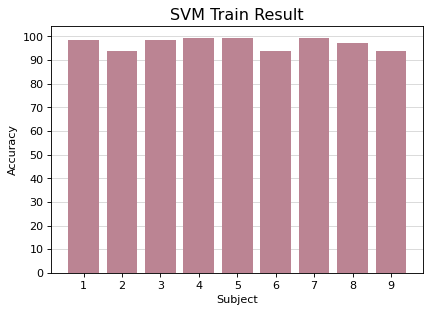

 Accuracy for all subjects 
Subject01 : 98.62%
Subject02 : 93.72%
Subject03 : 98.62%
Subject04 : 99.31%
Subject05 : 99.29%
Subject06 : 93.74%
Subject07 : 99.31%
Subject08 : 97.22%
Subject09 : 93.72%


In [86]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), eval_acc, color="#BB8493",  capsize=8)
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='SVM Train Result')
ax.set_axisbelow(True)
plt.savefig('SVM_train_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print(" Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f}%".format(i+1, eval_acc[i]))


In [87]:
# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    # Prepare train and test data
    data_train = modified_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']
    
    data_test = modified_dataE[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']
    
    # Training the model + train accuracy
    model1.fit(X_train, y_train)
    tr_score = model1.score(X_train, y_train)*100
    te_score = model1.score(X_test, y_test)*100
    
    train_score.append(tr_score)
    test_score.append(te_score)

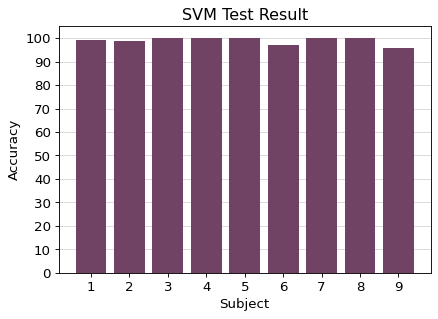

Test Accuracy for all subjects 
Subject01 : 99.31 %
Subject02 : 98.61 %
Subject03 : 100.00 %
Subject04 : 100.00 %
Subject05 : 100.00 %
Subject06 : 97.22 %
Subject07 : 100.00 %
Subject08 : 100.00 %
Subject09 : 95.83 %


In [88]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), test_score, color="#704264")
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='SVM Test Result')
ax.set_axisbelow(True)
plt.savefig('SVM_test_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("Test Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))

# KNN 

In [89]:
from sklearn.neighbors import KNeighborsClassifier

# Define model with specified hyperparameters
model2 = KNeighborsClassifier(n_neighbors=50)  # You can adjust n_neighbors as needed
# Get the parameters of the model
model2.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 50,
 'p': 2,
 'weights': 'uniform'}

In [90]:
# Iterate over each subject
eval_acc = []


for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    print('Processing for {}'.format(subj))
    X_train = modified_data[subj]['train']['mutual']['X']
    y_train = modified_data[subj]['train']['mutual']['y']
    
    eval_acc.append(cross_val_score(model2, X_train, y_train).mean()*100)
    
eval_acc    

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


[98.62068965517243,
 94.43349753694582,
 97.93103448275862,
 97.93103448275862,
 99.28571428571429,
 93.05418719211822,
 100.0,
 98.62068965517243,
 90.24630541871922]

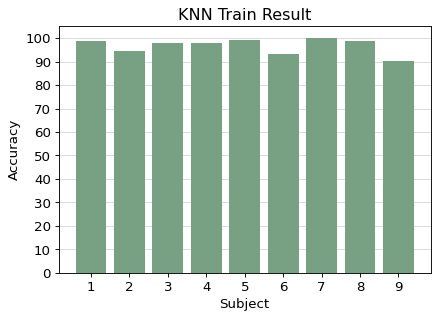

 Accuracy for all subjects 
Subject01 : 98.62%
Subject02 : 94.43%
Subject03 : 97.93%
Subject04 : 97.93%
Subject05 : 99.29%
Subject06 : 93.05%
Subject07 : 100.00%
Subject08 : 98.62%
Subject09 : 90.25%


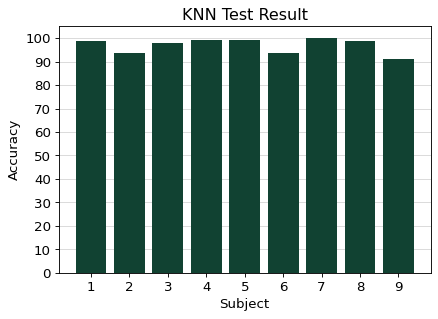

Test Accuracy for all subjects 
Subject01 : 98.61 %
Subject02 : 93.75 %
Subject03 : 97.92 %
Subject04 : 99.31 %
Subject05 : 99.31 %
Subject06 : 93.75 %
Subject07 : 100.00 %
Subject08 : 98.61 %
Subject09 : 90.97 %


In [91]:
# Necessary variable to label x axis
subject=[]
for i in range(1, Number_subject):
    subject.append(subject_counter(i))
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), eval_acc, color="#78A083",  capsize=8)
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='KNN Train Result')
ax.set_axisbelow(True)
plt.savefig('KNNResult.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print(" Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f}%".format(i+1, eval_acc[i]))

# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    # Prepare train and test data
    data_train = modified_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']
    
    data_test = modified_dataE[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']
    
    # Training the model + train accuracy
    model2.fit(X_train, y_train)
    tr_score = model2.score(X_train, y_train)*100
    te_score = model2.score(X_test, y_test)*100
    
    train_score.append(tr_score)
    test_score.append(te_score)
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), test_score, color="#114232")
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='KNN Test Result')
ax.set_axisbelow(True)
plt.savefig('KNNtestResult.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("Test Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))    

# Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression

# Define model with specified hyperparameters
model3 = LogisticRegression(max_iter=3500,C=0.5)  # You can adjust max_iter as needed

# Get the parameters of the model
model3.get_params()


{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [93]:
# Iterate over each subject
eval_acc = []


for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    print('Processing for {}'.format(subj))
    X_train = modified_data[subj]['train']['mutual']['X']
    y_train = modified_data[subj]['train']['mutual']['y']
    
    eval_acc.append(cross_val_score(model3, X_train, y_train).mean()*100)
    
eval_acc    

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


[98.62068965517243,
 95.09852216748769,
 97.93103448275862,
 98.62068965517243,
 99.28571428571429,
 92.36453201970443,
 100.0,
 97.21674876847291,
 91.62561576354679]

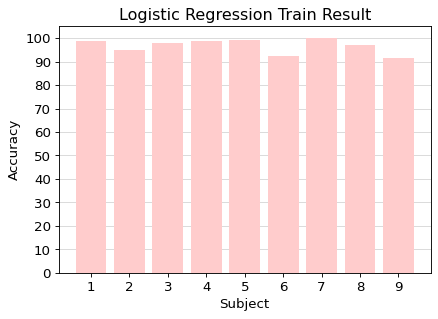

 Accuracy for all subjects 
Subject01 : 98.62%
Subject02 : 95.10%
Subject03 : 97.93%
Subject04 : 98.62%
Subject05 : 99.29%
Subject06 : 92.36%
Subject07 : 100.00%
Subject08 : 97.22%
Subject09 : 91.63%


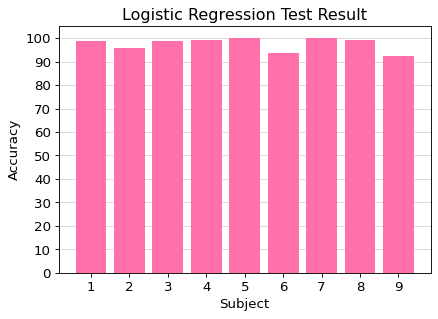

Test Accuracy for all subjects 
Subject01 : 98.61 %
Subject02 : 95.83 %
Subject03 : 98.61 %
Subject04 : 99.31 %
Subject05 : 100.00 %
Subject06 : 93.75 %
Subject07 : 100.00 %
Subject08 : 99.31 %
Subject09 : 92.36 %


In [94]:
# Necessary variable to label x axis
subject=[]
for i in range(1, Number_subject):
    subject.append(subject_counter(i))
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), eval_acc, color="#FFCCCC",  capsize=8)
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='Logistic Regression Train Result')
ax.set_axisbelow(True)
plt.savefig('LogisticRegressionTrainResult.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print(" Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f}%".format(i+1, eval_acc[i]))

# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    # Prepare train and test data
    data_train = modified_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']
    
    data_test = modified_dataE[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']
    
    # Training the model + train accuracy
    model3.fit(X_train, y_train)
    tr_score = model3.score(X_train, y_train)*100
    te_score = model3.score(X_test, y_test)*100
    
    train_score.append(tr_score)
    test_score.append(te_score)
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), test_score, color="#FF70AB")
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='Logistic Regression Test Result')
ax.set_axisbelow(True)
plt.savefig('LogisticRegressionTestResult.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("Test Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))    

# Decision Tree 

In [95]:
from sklearn.tree import DecisionTreeClassifier
model4= DecisionTreeClassifier()  

# Get the parameters of the model
model4.get_params()



{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [96]:
# Iterate over each subject
eval_acc = []


for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    print('Processing for {}'.format(subj))
    X_train = modified_data[subj]['train']['mutual']['X']
    y_train = modified_data[subj]['train']['mutual']['y']
    
    eval_acc.append(cross_val_score(model4, X_train, y_train).mean()*100)
    
eval_acc    

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


[89.58128078817735,
 74.90147783251231,
 92.38916256157636,
 80.51724137931035,
 83.99014778325122,
 77.78325123152709,
 90.22167487684729,
 96.5270935960591,
 83.30049261083744]

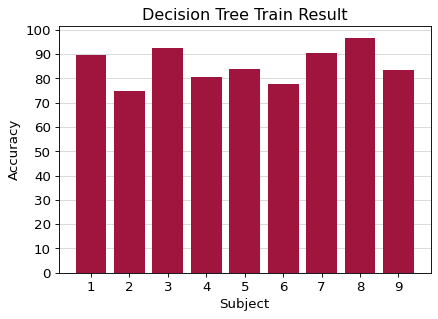

 Accuracy for all subjects 
Subject01 : 89.58%
Subject02 : 74.90%
Subject03 : 92.39%
Subject04 : 80.52%
Subject05 : 83.99%
Subject06 : 77.78%
Subject07 : 90.22%
Subject08 : 96.53%
Subject09 : 83.30%


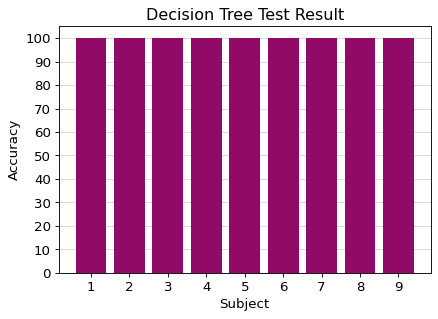

Test Accuracy for all subjects 
Subject01 : 100.00 %
Subject02 : 100.00 %
Subject03 : 100.00 %
Subject04 : 100.00 %
Subject05 : 100.00 %
Subject06 : 100.00 %
Subject07 : 100.00 %
Subject08 : 100.00 %
Subject09 : 100.00 %


In [97]:
# Necessary variable to label x axis
subject=[]
for i in range(1, Number_subject):
    subject.append(subject_counter(i))
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), eval_acc, color="#A0153E",  capsize=8)
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='Decision Tree Train Result')
ax.set_axisbelow(True)
plt.savefig('DecisionTreetrain.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print(" Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f}%".format(i+1, eval_acc[i]))

# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, Number_subject):
    subj = subject_counter(i)
    
    # Prepare train and test data
    data_train = modified_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']
    
    data_test = modified_dataE[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']
    
    # Training the model + train accuracy
    model4.fit(X_train, y_train)
    tr_score = model4.score(X_train, y_train)*100
    te_score = model4.score(X_test, y_test)*100
    
    train_score.append(tr_score)
    test_score.append(te_score)
    
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, Number_subject), test_score, color="#910A67")
ax.set(xticks=np.arange(1, Number_subject), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='Decision Tree Test Result')
ax.set_axisbelow(True)
plt.savefig('DecisionTreetest .jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("Test Accuracy for all subjects ")
for i in range(9):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))    

In [98]:
import pickle

# Save the model to disk
filename = 'finalized_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model1, file)

print(f"Model saved to {filename}")


Model saved to finalized_model.pkl
